# 1. **Import Libraries**

In [1]:
import shutil
import pathlib
import random
from pathlib import Path
import os
import shutil

import pandas as pd
import tensorflow as tf
from collections import Counter
from PIL import Image
import seaborn as sns

import torch
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Dataset
from torch import nn
from tqdm.auto import tqdm
from timeit import default_timer as timer
from typing import Dict, List, Tuple, Any
from torch.cuda.amp import GradScaler, autocast

import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

#ensure torchinfo is installed

try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

print(f"torchinfo: {torchinfo.__version__}")

import warnings
warnings.filterwarnings("ignore")

2025-06-23 03:49:57.742650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750650597.778317     429 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750650597.789360     429 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


torchinfo: 1.8.0


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The available device is: {device}")

The available device is: cuda


# **2. Helping Functions**

## 2.1 Train Step

In [3]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               optimizer: torch.optim.Optimizer,
               loss_fn: torch.nn.Module,
               device: torch.device,
               scaler: GradScaler) -> Tuple[float, float]:

    model.to(device)
    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        # 1. Forward pass with autocast for mixed precision
        with autocast():
            y_pred = model(X)
            loss = loss_fn(y_pred, y)

        train_loss += loss.item()

        # 2. Backward pass with scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # 3. Accuracy calculation (outside autocast)
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += ((y_pred_class == y).sum().item() / len(y_pred))

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    return train_loss, train_acc

## 2.2 Validation Step

In [4]:
def valid_step(model:nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               device: torch.device) -> Tuple[float, float]:

  model.to(device)
  model.eval()
  valid_loss, valid_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)

      #1. forward pass
      valid_pred_logits = model(X)

      #2. calculate the loss
      loss = loss_fn(valid_pred_logits, y)
      valid_loss += loss.item()

      #3. calculate accuracy
      valid_pred_labels = valid_pred_logits.argmax (dim = 1)
      valid_acc += ((valid_pred_labels == y).sum().item()/len(valid_pred_logits))

    valid_loss /= len(data_loader)
    valid_acc /= len(data_loader)

    return valid_loss, valid_acc

## 2.3 Training Loop

In [5]:
def train_model(model: nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                valid_dataloader: torch.utils.data.DataLoader,
                optimizer: torch.optim.Optimizer,
                loss_fn: nn.Module,
                epochs: int,
                device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [],
               "train_acc": [],
               "valid_loss": [],
               "valid_acc": []}

    model.to(device)
    scaler = GradScaler() 
    patience = 0          
    highest_score = float("inf")

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device,
                                           scaler=scaler)  

        valid_loss, valid_acc = valid_step(model=model,
                                           loss_fn=loss_fn,
                                           device=device,
                                           data_loader=valid_dataloader)

        # Early stopping logic
        if valid_loss < highest_score:
            highest_score = valid_loss
            patience = 0
            best_model_state = model.state_dict()  # Save best model
        else:
            patience += 1
            if patience >= 10:
                print(f"Training early-stopped after epoch {epoch+1}")
                break

        # Logging
        print(f"Epoch: {epoch + 1} | "
              f"train_loss: {train_loss:.3f} | "
              f"train_acc: {train_acc * 100:.2f}% | "
              f"valid_loss: {valid_loss:.3f} | "
              f"valid_acc: {valid_acc * 100:.2f}%")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)

    return results

## 2.4 Prediction

In [6]:
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: transforms.Compose,
                   class_names: List[str],
                   device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")) -> List[Dict]:

    # Create an empty list to store prediction dictionaries
    pred_list = []

    # Loop through the target paths
    for path in tqdm(paths):
      # Create empty dictionary to store prediction information for each sample
      pred_dict = {}
      # Get the sample path and ground truth class name
      pred_dict["image_path"] = path
      class_name = path.parent.stem
      pred_dict["class_name"] = class_name

      # Start a timer
      start_time = timer()

      # Open image path and convert to RGB
      img = Image.open(path)

      # Transform the image, add batch dimension, and send to device
      transformed_image = transform(img).unsqueeze(0).to(device)

      # Prepare model for inference
      model.to(device)
      model.eval()

      # Get prediction
      with torch.inference_mode():
        pred_logit = model(transformed_image)
        try:
          pred_logit = pred_logit.logits
        except:
          pred_logit = pred_logit

        pred_prob = torch.softmax(pred_logit, dim=1) #turn logits into prediction probabilities
        pred_label = torch.argmax(pred_prob, dim=1) #turn prediction probabilities into prediction label
        pred_class = class_names[pred_label.cpu()] #hardcore prediction class on CPU

        # Store prediction results
        pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict["pred_label"] = pred_class

        # End timer (optional)
        end_time = timer()
        pred_dict["time_per_pred"] = round(end_time - start_time, 4)

      # Match prediction to true label
      pred_dict["correct"] = class_name == pred_class

      # Append to results list
      pred_list.append(pred_dict)

    return pred_list

## 2.5 Model Evaluation on Test Dataset

In [7]:
def pred_and_plot_image(model:nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):
  img = Image.open(image_path)

  if transform is not None:
    image_transform = transform

  else:
    image_transform =  transforms.Compose([
    transforms.Resize((224, 224)), #some models may require different sizes
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                        std = [0.229, 0.224, 0.225])
])
  model.to(device)
  model.eval()
  with torch.inference_mode():
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

### 2.5 Calculate Accurcay

In [8]:
def accuracy_fn(y_true, y_pred):
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 2.6 Model inference on the test dataset

In [9]:
def get_preds_and_labels(model, dataloader, device):
    model.eval()
    y_pred = []
    y_true = []
    y_probs = []

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            logits = model(X)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            y_pred.extend(preds.cpu().tolist())
            y_true.extend(y.cpu().tolist())
            y_probs.extend(probs.cpu().tolist())

    return y_true, y_pred, y_probs

## 2.7 Model prediction

In [10]:
def predict(img) -> Tuple[Dict, float]:
  '''Transforms and performs a prediction on img and returns prediction and time taken'''
  #start a timer
  start_time = timer()

  #Transform the target image and add batch dimension
  img = auto_transforms(img).unsqueeze(0)

  #put model into evaluation mode and turn on inference mode
  model.eval()
  with torch.inference_mode():
    #pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(model(img), dim=1)

  #create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #calculate the prediction time
  pred_time = round(timer() - start_time, 5)


  return pred_labels_and_probs, pred_time

In [11]:
#set hyperparameters
EPOCHS = 50
FINE_TUNE_EPOCHS = 25
BATCH_SIZE = 32
num_workers = os.cpu_count()
IMG_SIZE = 224

In [12]:
train_dir = "/kaggle/input/foodvision-101-subset/train"
test_dir = "/kaggle/input/foodvision-101-subset/test"

# 3. **Download the Pre-Trained Model**

In [13]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [14]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [15]:
#trabnsformation for images plotting
manual_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  
    transforms.ToTensor(),          
])

# 4. **Create Datasets for Data visualization**

In [16]:
train_data = ImageFolder(root = train_dir, transform = manual_transform)
test_data = ImageFolder(root = test_dir)

In [17]:
data = {'Subset': ['Train', 'Test'],
        'Count': [len(train_data), len(test_data)]}

df = pd.DataFrame(data)

fig = px.bar(df, x='Subset', y='Count', color='Subset',
             color_discrete_sequence=["lightgreen", "lightblue"],
             text='Count')

fig.update_layout(title='Count of images in Train and Test subsets',
                  xaxis_title="Subset",
                  yaxis_title="Count",
                  height=900, width=900)

fig.show()

## Dataset Class Distribution

In [18]:
class_names = train_data.classes 

class_counts = Counter(train_data.targets)

data_per_class = {'Class': (class_names[i] for i in class_counts.keys()), 'Count': list(class_counts.values())}
data_per_class_df = pd.DataFrame(data_per_class)

fig = px.bar(data_per_class_df, x='Count', y='Class', text='Count',
             color='Class', color_discrete_sequence=px.colors.qualitative.Bold)

fig.update_layout(title='Number of Images per Class',
                  xaxis_title='Class',
                  yaxis_title='Image Count',
                  height=900, width=900)
fig.show()

## Classes Visualization

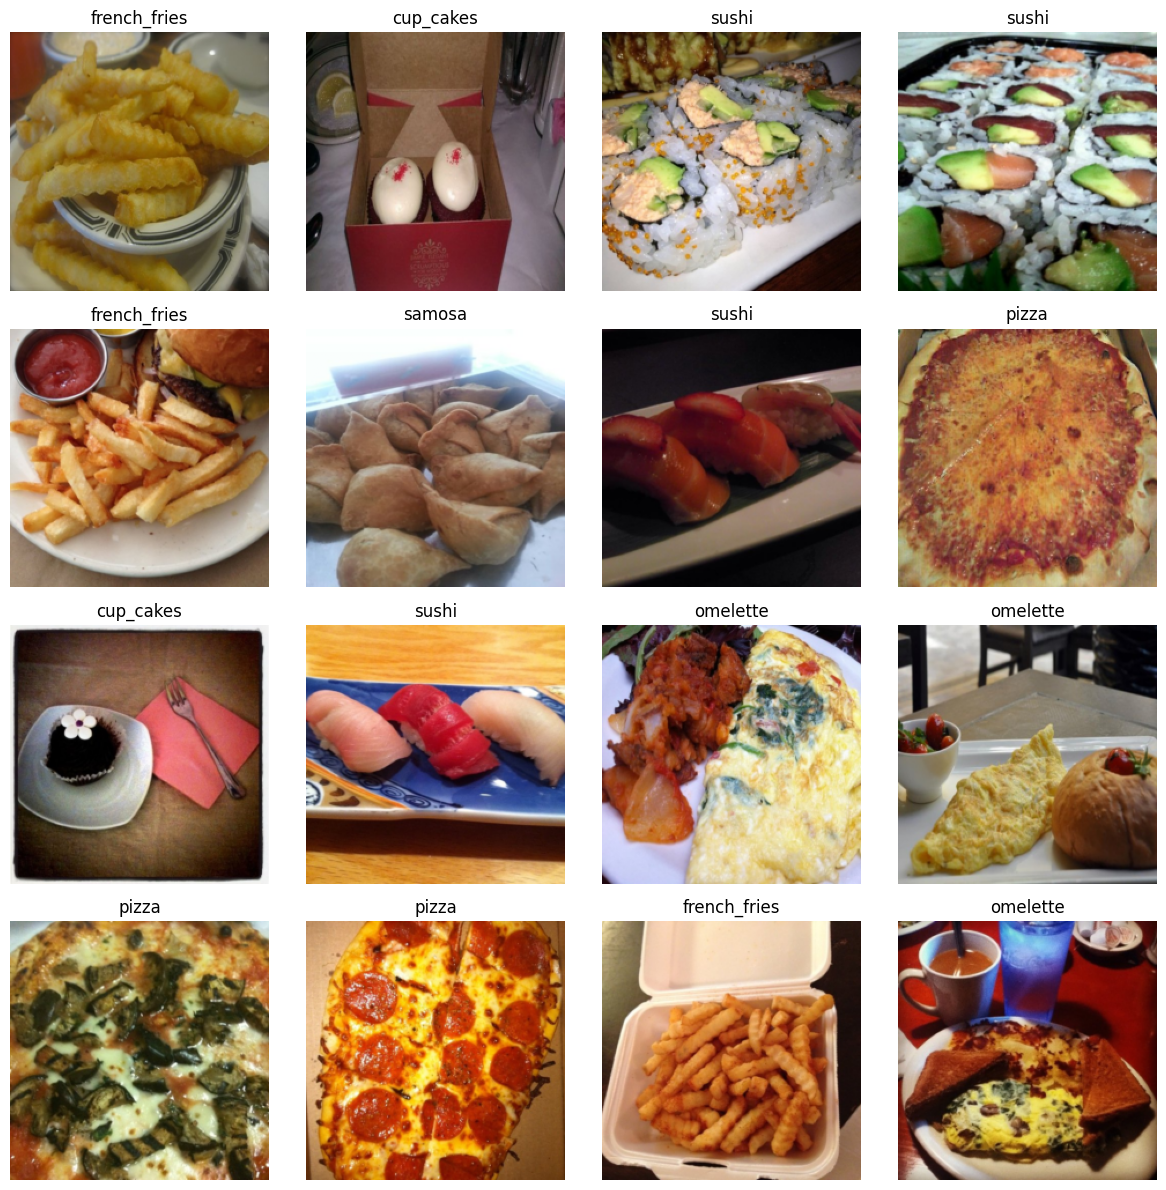

In [19]:
torch.manual_seed(42)

fig = plt.figure(figsize=(12, 12))
rows, cols = 4,4


for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]

    img = img.permute(1, 2, 0)

    fig.add_subplot(rows, cols, i)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

# **4. Data Splitting**

In [20]:
raw_data = ImageFolder(train_dir)


train_size = int(0.8 * len(raw_data))
valid_size = len(raw_data) - train_size
train_subset, valid_subset = random_split(raw_data, [train_size, valid_size], generator=torch.Generator().manual_seed(42))

# **5. Apply Data Augmentation**

In [21]:
class TransformSubsets(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return self.transform(img), label

    def __len__(self):
        return len(self.subset)

In [22]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((int(IMG_SIZE * 1.14))),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [23]:
train_dataset = TransformSubsets(train_subset, train_transform)
valid_dataset = TransformSubsets(valid_subset, valid_test_transform)


test_dataset = ImageFolder(test_dir, transform=valid_test_transform)

# **6. Create Dataloaders**

In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [25]:
summary(model = model, input_size = (BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

# 7. **Freeze Feature-Extractor layers**

In [26]:
for param in model.features.parameters():
  param.requires_grad = False

In [27]:
for name, param in model.named_parameters():
  if param.requires_grad:
    print(name)

classifier.1.weight
classifier.1.bias


# 8. **Create the model** 

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
out_shape = len(class_names)

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, out_features = out_shape)).to(device)

In [29]:
summary(model = model,
        input_size = (32, 3, 224, 224),
        verbose=0,
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 7]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-3, weight_decay = 0.1)

# **9. Train Model**

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
start_time = timer()
epochs = EPOCHS

#model=torch.compile(model)

results = train_model(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device)


end_time = timer()
print(f"[INFO] Total training time is: {end_time-start_time:.3f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.187 | train_acc: 68.51% | valid_loss: 0.818 | valid_acc: 82.12%
Epoch: 2 | train_loss: 0.848 | train_acc: 79.33% | valid_loss: 0.750 | valid_acc: 84.01%
Epoch: 3 | train_loss: 0.806 | train_acc: 80.45% | valid_loss: 0.730 | valid_acc: 83.82%
Epoch: 4 | train_loss: 0.789 | train_acc: 80.71% | valid_loss: 0.709 | valid_acc: 84.84%
Epoch: 5 | train_loss: 0.793 | train_acc: 80.71% | valid_loss: 0.720 | valid_acc: 84.11%
Epoch: 6 | train_loss: 0.794 | train_acc: 80.11% | valid_loss: 0.719 | valid_acc: 83.89%
Epoch: 7 | train_loss: 0.795 | train_acc: 80.07% | valid_loss: 0.724 | valid_acc: 84.11%
Epoch: 8 | train_loss: 0.786 | train_acc: 81.13% | valid_loss: 0.718 | valid_acc: 83.61%
Epoch: 9 | train_loss: 0.786 | train_acc: 80.61% | valid_loss: 0.712 | valid_acc: 84.01%
Epoch: 10 | train_loss: 0.794 | train_acc: 80.02% | valid_loss: 0.727 | valid_acc: 84.67%
Epoch: 11 | train_loss: 0.792 | train_acc: 80.33% | valid_loss: 0.708 | valid_acc: 84.65%
Epoch: 12 | train_l

# **10. Fine-Tuning**

In [32]:
for param in model.features[-4:].parameters():
  param.requires_grad = True

In [33]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 1e-5, weight_decay = 1e-3)

In [34]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
start_time = timer()
epochs = FINE_TUNE_EPOCHS

#model=torch.compile(model)

results = train_model(
    model=model,
    train_dataloader=train_dataloader,
    valid_dataloader=valid_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=epochs,
    device=device)


end_time = timer()
print(f"[INFO] Total training time is: {end_time-start_time:.3f}")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.677 | train_acc: 83.81% | valid_loss: 0.548 | valid_acc: 87.63%
Epoch: 2 | train_loss: 0.557 | train_acc: 85.25% | valid_loss: 0.464 | valid_acc: 88.24%
Epoch: 3 | train_loss: 0.474 | train_acc: 87.33% | valid_loss: 0.402 | valid_acc: 88.93%
Epoch: 4 | train_loss: 0.415 | train_acc: 88.78% | valid_loss: 0.355 | valid_acc: 89.40%
Epoch: 5 | train_loss: 0.383 | train_acc: 89.56% | valid_loss: 0.341 | valid_acc: 90.25%
Epoch: 6 | train_loss: 0.348 | train_acc: 89.80% | valid_loss: 0.312 | valid_acc: 91.30%
Epoch: 7 | train_loss: 0.331 | train_acc: 90.22% | valid_loss: 0.287 | valid_acc: 91.27%
Epoch: 8 | train_loss: 0.290 | train_acc: 91.71% | valid_loss: 0.273 | valid_acc: 91.70%
Epoch: 9 | train_loss: 0.268 | train_acc: 92.09% | valid_loss: 0.259 | valid_acc: 91.96%
Epoch: 10 | train_loss: 0.258 | train_acc: 93.06% | valid_loss: 0.258 | valid_acc: 92.24%
Epoch: 11 | train_loss: 0.237 | train_acc: 93.39% | valid_loss: 0.241 | valid_acc: 92.53%
Epoch: 12 | train_l

# **11. Save the model**

In [35]:
torch.save(model.state_dict(), "/kaggle/working/my_model.pth")
print("Model Saved")

Model Saved


# **12. Model Evaluation on the test dataset**

In [36]:
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:10]

[INFO] Finding all filepaths ending with '.jpg' in directory: /kaggle/input/foodvision-101-subset/test


[PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/2545807.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/724405.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/2138489.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/1501298.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/2646189.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/3270931.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/3548404.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/1792519.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/568560.jpg'),
 PosixPath('/kaggle/input/foodvision-101-subset/test/omelette/3902864.jpg')]

## 12.1 Model predictions ***DataFrame***

In [37]:
model_test_pred_dicts = pred_and_store(paths = test_data_paths,
                                     model = model,
                                     transform = valid_test_transform,
                                     class_names = class_names,
                                     device = "cpu")

  0%|          | 0/1750 [00:00<?, ?it/s]

In [38]:
model_test_pred_df = pd.DataFrame(model_test_pred_dicts)
model_test_pred_df.head()

,image_path,class_name,pred_prob,pred_label,time_per_pred,correct
0,/kaggle/input/foodvision-101-subset/test/omele...,omelette,0.9633,omelette,0.5313,True
1,/kaggle/input/foodvision-101-subset/test/omele...,omelette,0.9610,omelette,0.0551,True
2,/kaggle/input/foodvision-101-subset/test/omele...,omelette,1.0000,omelette,0.0493,True
3,/kaggle/input/foodvision-101-subset/test/omele...,omelette,0.9999,omelette,0.0533,True
4,/kaggle/input/foodvision-101-subset/test/omele...,omelette,0.9789,omelette,0.0478,True


In [39]:
model_test_pred_df.correct.value_counts()

correct
True     1656
False      94
Name: count, dtype: int64

## 12.2 Model Evaluation with random samples

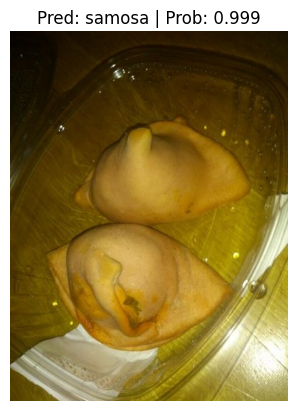

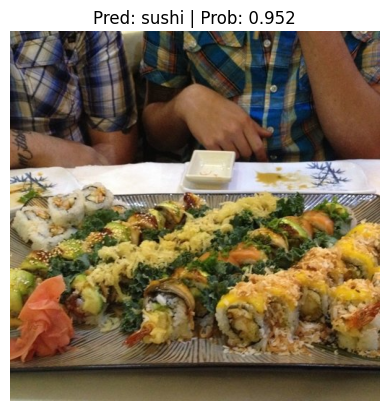

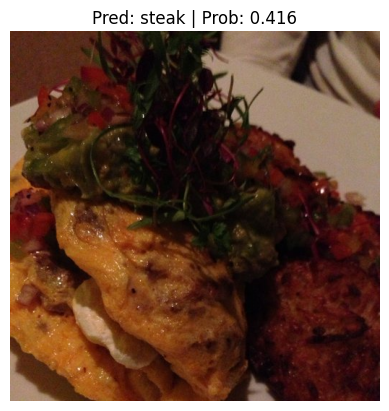

In [40]:
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list, k=num_images_to_plot)

for image_parg in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_parg,
                      class_names=class_names,
                      image_size=(224, 224))

In [41]:
y_true, y_pred, y_probs = get_preds_and_labels(model, test_dataloader, device)

In [42]:
test_acc = accuracy_fn(y_true, y_pred)
print(f"The Accuracy on the Test Dataset is {test_acc:.3f}%")

The Accuracy on the Test Dataset is 94.629%


## 12.3 Classification Report

In [43]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   cup_cakes       0.97      0.96      0.97       250
french_fries       0.96      1.00      0.98       250
    omelette       0.91      0.90      0.90       250
       pizza       0.95      0.97      0.96       250
      samosa       0.94      0.95      0.95       250
       steak       0.93      0.94      0.93       250
       sushi       0.97      0.91      0.94       250

    accuracy                           0.95      1750
   macro avg       0.95      0.95      0.95      1750
weighted avg       0.95      0.95      0.95      1750



## 12.4 Confusion Matrix

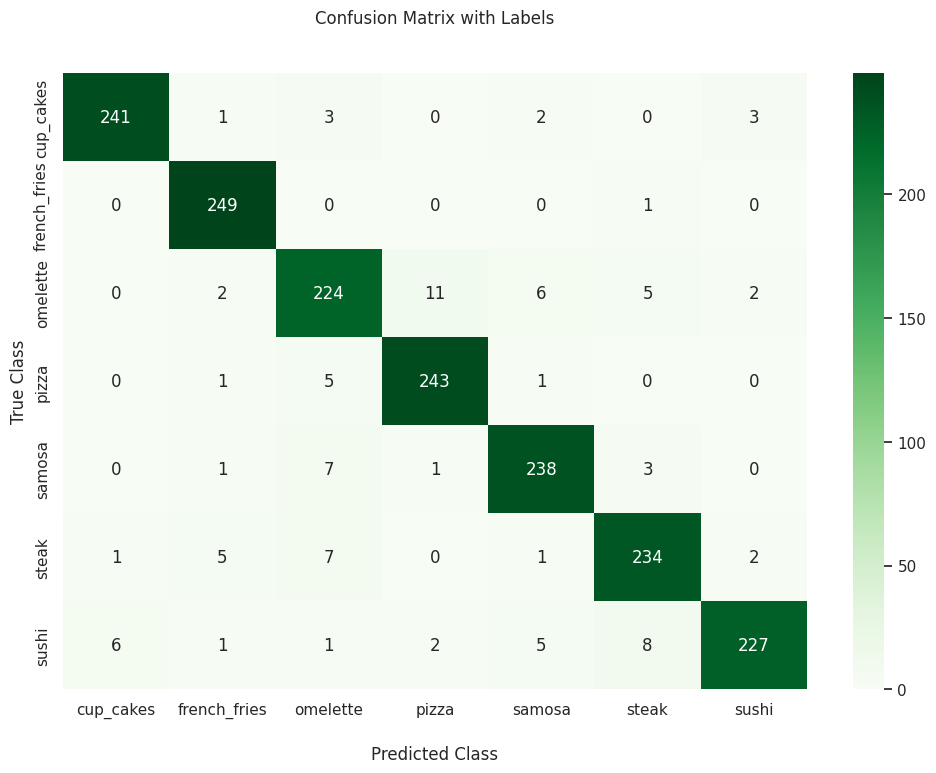

In [44]:
confusionMatrix = confusion_matrix(y_true, y_pred)

sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.heatmap(confusionMatrix, annot=True, cmap='Greens', fmt='g')

ax.set_title('Confusion Matrix with Labels\n\n');
ax.set_xlabel('\nPredicted Class')
ax.set_ylabel('True Class');

ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

plt.show()